In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
import sklearn
from importlib import reload
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data = yf.download("MU", start="2014-01-01", end=dt.date.today())
df = data.reset_index()
df = data['Close']
df = pd.DataFrame(df)
df_type = df.copy()
df.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2013-12-31,21.750000
2014-01-02,21.660000
2014-01-03,20.969999
2014-01-06,20.670000
2014-01-07,21.730000


In [3]:
# set label = 1 day ahead
df['Label']= df['Close'].shift(-1)
df

,Close,Label
Date,,
2013-12-31,21.750000,21.660000
2014-01-02,21.660000,20.969999
2014-01-03,20.969999,20.670000
2014-01-06,20.670000,21.730000
2014-01-07,21.730000,23.870001
...,...,...
2022-09-12,57.939999,53.619999
2022-09-13,53.619999,53.110001
2022-09-14,53.110001,52.689999


### feature Stochastic

In [4]:
# find out the highest price and lowest price
# create the "Ln" column in the DataFrame
df['Ln'] = data['Low'].rolling(window=5).min()
# create the "Hn" column in the DataFrame
df['Hn'] = data['High'].rolling(window=5).max()

#### Using technical indicators and formula no.1 (Type 1).[Stochastic %K->(Ct − Ln)/(Hn − Ln)×100],
#where (Ct= Closing price, Ln=Lowest low price, Hn= Highest high price)


In [5]:
StochasticK =(100*((data['Close'] - df['Ln']) / (df['Hn'] - df['Ln']) ))
df['StochasticK'] = StochasticK.shift(-1)
StochasticK.dropna().head()

Date
2014-01-07    83.846092
2014-01-08    83.678781
2014-01-09    67.357512
2014-01-10    79.533658
2014-01-13    67.590031
dtype: float64

In [6]:
df.tail()

,Close,Label,Ln,Hn,StochasticK
Date,,,,,
2022-09-12,57.939999,53.619999,53.740002,58.139999,9.599991
2022-09-13,53.619999,53.110001,53.139999,58.139999,11.443688
2022-09-14,53.110001,52.689999,52.459999,58.139999,11.525959
2022-09-15,52.689999,52.849998,51.980000,58.139999,20.451087
2022-09-16,52.849998,NaN,51.490002,58.139999,NaN


### feature OSCP

In [7]:
# Formula data: OSCP (price oscillator)	MA5 − MA10/MA5
df['Close_MA5']= df['Close'].rolling(5).mean()
df['Close_MA10']= df['Close'].rolling(10).mean()
OSCP= df['Close_MA5'] - df["Close_MA10"]/df["Close_MA5"]
df['OSCP']= OSCP.shift(-1)
OSCP.dropna().head()

Date
2014-01-14    22.610851
2014-01-15    22.491726
2014-01-16    22.462548
2014-01-17    22.179308
2014-01-21    22.124919
dtype: float64

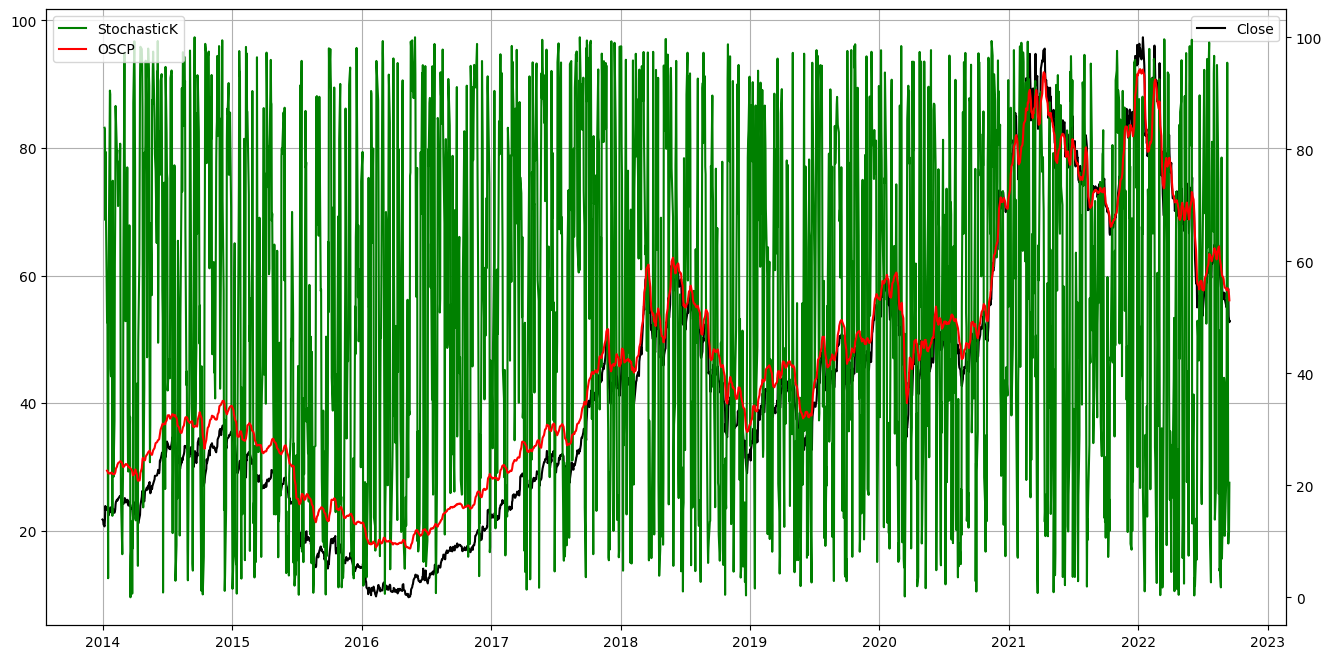

In [8]:
# visualizing price and features in the same graph 
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(df['Close'], label='Close', color='black')
plt.legend(loc='upper right')
plt.grid()

# get second axis
ax2 = ax.twinx() 
plt.plot(df['StochasticK'], label='StochasticK',color='green')
plt.plot(df['OSCP'], label='OSCP',color='red')
plt.legend(loc='upper left')
plt.show()

### Regression and Plot based on the features, forecast 1-day ahead

In [9]:
# rename the label
label1= df.shift(-1)
label1 = label1.rename({'Close':'Close_label', 'StochasticK':'StochasticK_label', 'OSCP':'OSCP_label'}, axis='columns')


In [10]:
# merge table and drop NaN value
merged_table = pd.merge(df, label1, on='Date')
merged_table=merged_table.dropna()
df.tail()

,Close,Label,Ln,Hn,StochasticK,Close_MA5,Close_MA10,OSCP
Date,,,,,,,,
2022-09-12,57.939999,53.619999,53.740002,58.139999,9.599991,56.199999,56.448000,54.873865
2022-09-13,53.619999,53.110001,53.139999,58.139999,11.443688,55.877999,56.109000,54.494774
2022-09-14,53.110001,52.689999,52.459999,58.139999,11.525959,55.499999,55.790000,53.951884
2022-09-15,52.689999,52.849998,51.980000,58.139999,20.451087,54.959999,55.406000,53.025012
2022-09-16,52.849998,NaN,51.490002,58.139999,NaN,54.041999,54.959999,NaN


### StochasticK Regresssion

In [11]:
X_StochasticK = merged_table['StochasticK'].values
Y_StochasticK = merged_table['StochasticK_label'].values
X_StochasticK = X_StochasticK.reshape(-1,1)

In [12]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)
print(tscv) 

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [13]:
for train_index, test_index in tscv.split(X_StochasticK):
    x_train,x_test = X_StochasticK[train_index],X_StochasticK[test_index]
    y_train,y_test = Y_StochasticK[train_index],Y_StochasticK[test_index]

In [14]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)
Y_pred = regressor.predict(x_test)

In [15]:
StochasticK_X_test = x_test.copy()
StochasticK_Y_pred = Y_pred.copy()

In [16]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, ElasticNetCV, Ridge
from sklearn.neural_network import MLPRegressor

In [17]:
# create sklearn's model
linear = ElasticNetCV()

In [18]:
# train the model and reshape just to avoid error warning
linear.fit(x_train, y_train.reshape(len(y_train),))

ElasticNetCV()

In [19]:
# score returns the coefficient of determination R^2 of the prediction
linear.score(x_test, y_test)

0.3242410323528384

In [20]:
# uses the model to predict
forecast_StochasticK = linear.predict(x_test)
forecast_StochasticK[:5]

array([65.00854428, 63.01389017, 28.29578009, 29.59732589, 26.68827446])

In [21]:
# the actual labels for the featuresets
y_test[:5]

array([69.00444991, 13.48921456, 15.57042292, 10.9187678 , 16.11193568])

In [22]:
df1 = pd.DataFrame(forecast_StochasticK.reshape(-1,1),\
                index=data.index[-len(forecast_StochasticK):], columns=["Forecast_StochasticK"])
df1["StochasticK_Test"]= y_test
df1.head()

,Forecast_StochasticK,StochasticK_Test
Date,,
2021-04-12,65.008544,69.004450
2021-04-13,63.013890,13.489215
2021-04-14,28.295780,15.570423
2021-04-15,29.597326,10.918768
2021-04-16,26.688274,16.111936


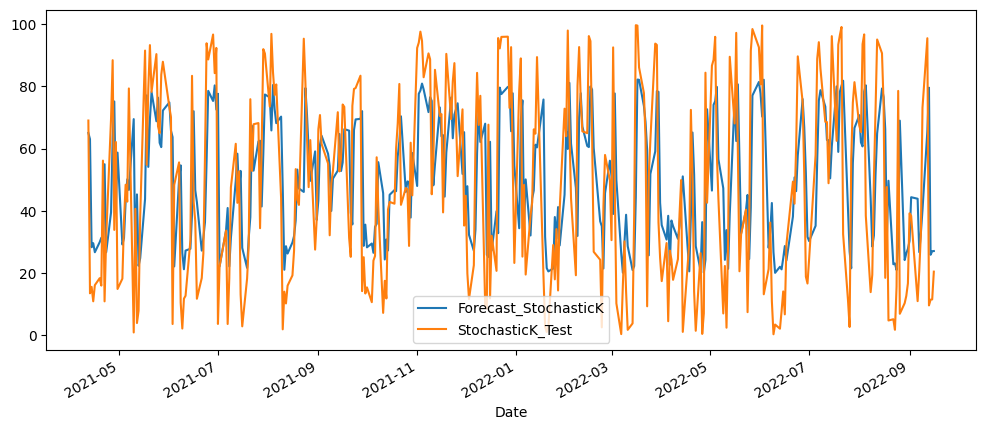

In [23]:
_ = df1.plot(figsize=(12,5))

### OSCP Regresssion

In [24]:
X_oscp = merged_table['OSCP'].values
Y_oscp = merged_table['OSCP_label'].values
X_oscp = X_oscp.reshape(-1,1)

In [25]:
for train_index, test_index in tscv.split(X_oscp):
    x_train,x_test = X_oscp[train_index],X_oscp[test_index]
    y_train,y_test = Y_oscp[train_index],Y_oscp[test_index]

In [26]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)
Y_pred = regressor.predict(x_test)

In [27]:
Oscp_X_test = x_test.copy()
Oscp_Y_pred = Y_pred.copy()

In [28]:
linear.fit(x_train, y_train.reshape(len(y_train),))

ElasticNetCV()

In [29]:
# score returns the coefficient of determination R^2 of the prediction
linear.score(x_test, y_test)

0.99221014858493

In [30]:
forecast_oscp = linear.predict(x_test)
forecast_oscp[:5]

array([93.46752499, 93.83150397, 93.5546757 , 92.88494575, 91.86731263])

In [31]:
df2 = pd.DataFrame(forecast_oscp.reshape(-1,1),\
                index=data.index[-len(forecast_oscp):], columns=["Forecast_OSCP"])
df2["OSCP_Test"] = y_test
df2.head()

,Forecast_OSCP,OSCP_Test
Date,,
2021-04-12,93.467525,93.753584
2021-04-13,93.831504,93.476940
2021-04-14,93.554676,92.807655
2021-04-15,92.884946,91.790697
2021-04-16,91.867313,90.854447


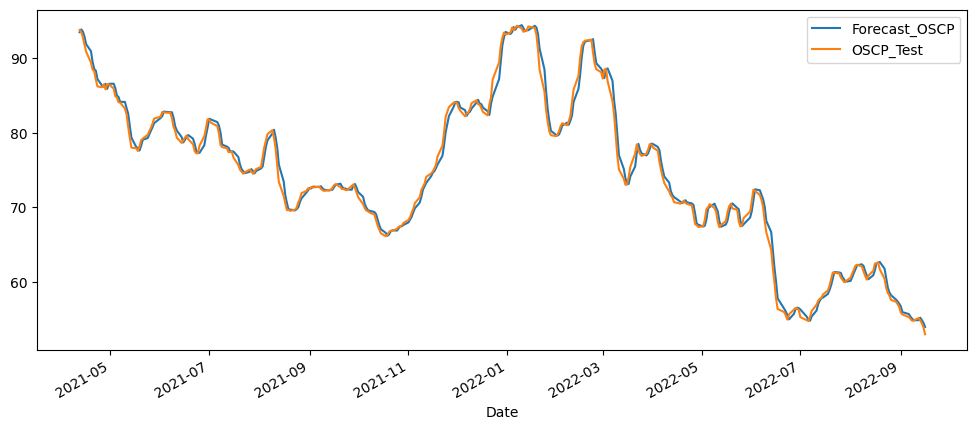

In [32]:
_ = df2.plot(figsize=(12,5))

In [33]:
# restranform the scaled data to original data
Scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
test1 = pd.Series(y_test)
test2 = pd.Series(y_test)
test_data = pd.DataFrame()
test_data = pd.concat([test2,test1], axis=1)
test_data.columns = ['Expected Output','Forecasted']

In [34]:
df3 = pd.concat([df1, df2], axis=1, join='inner')

<IPython.core.display.Javascript object>


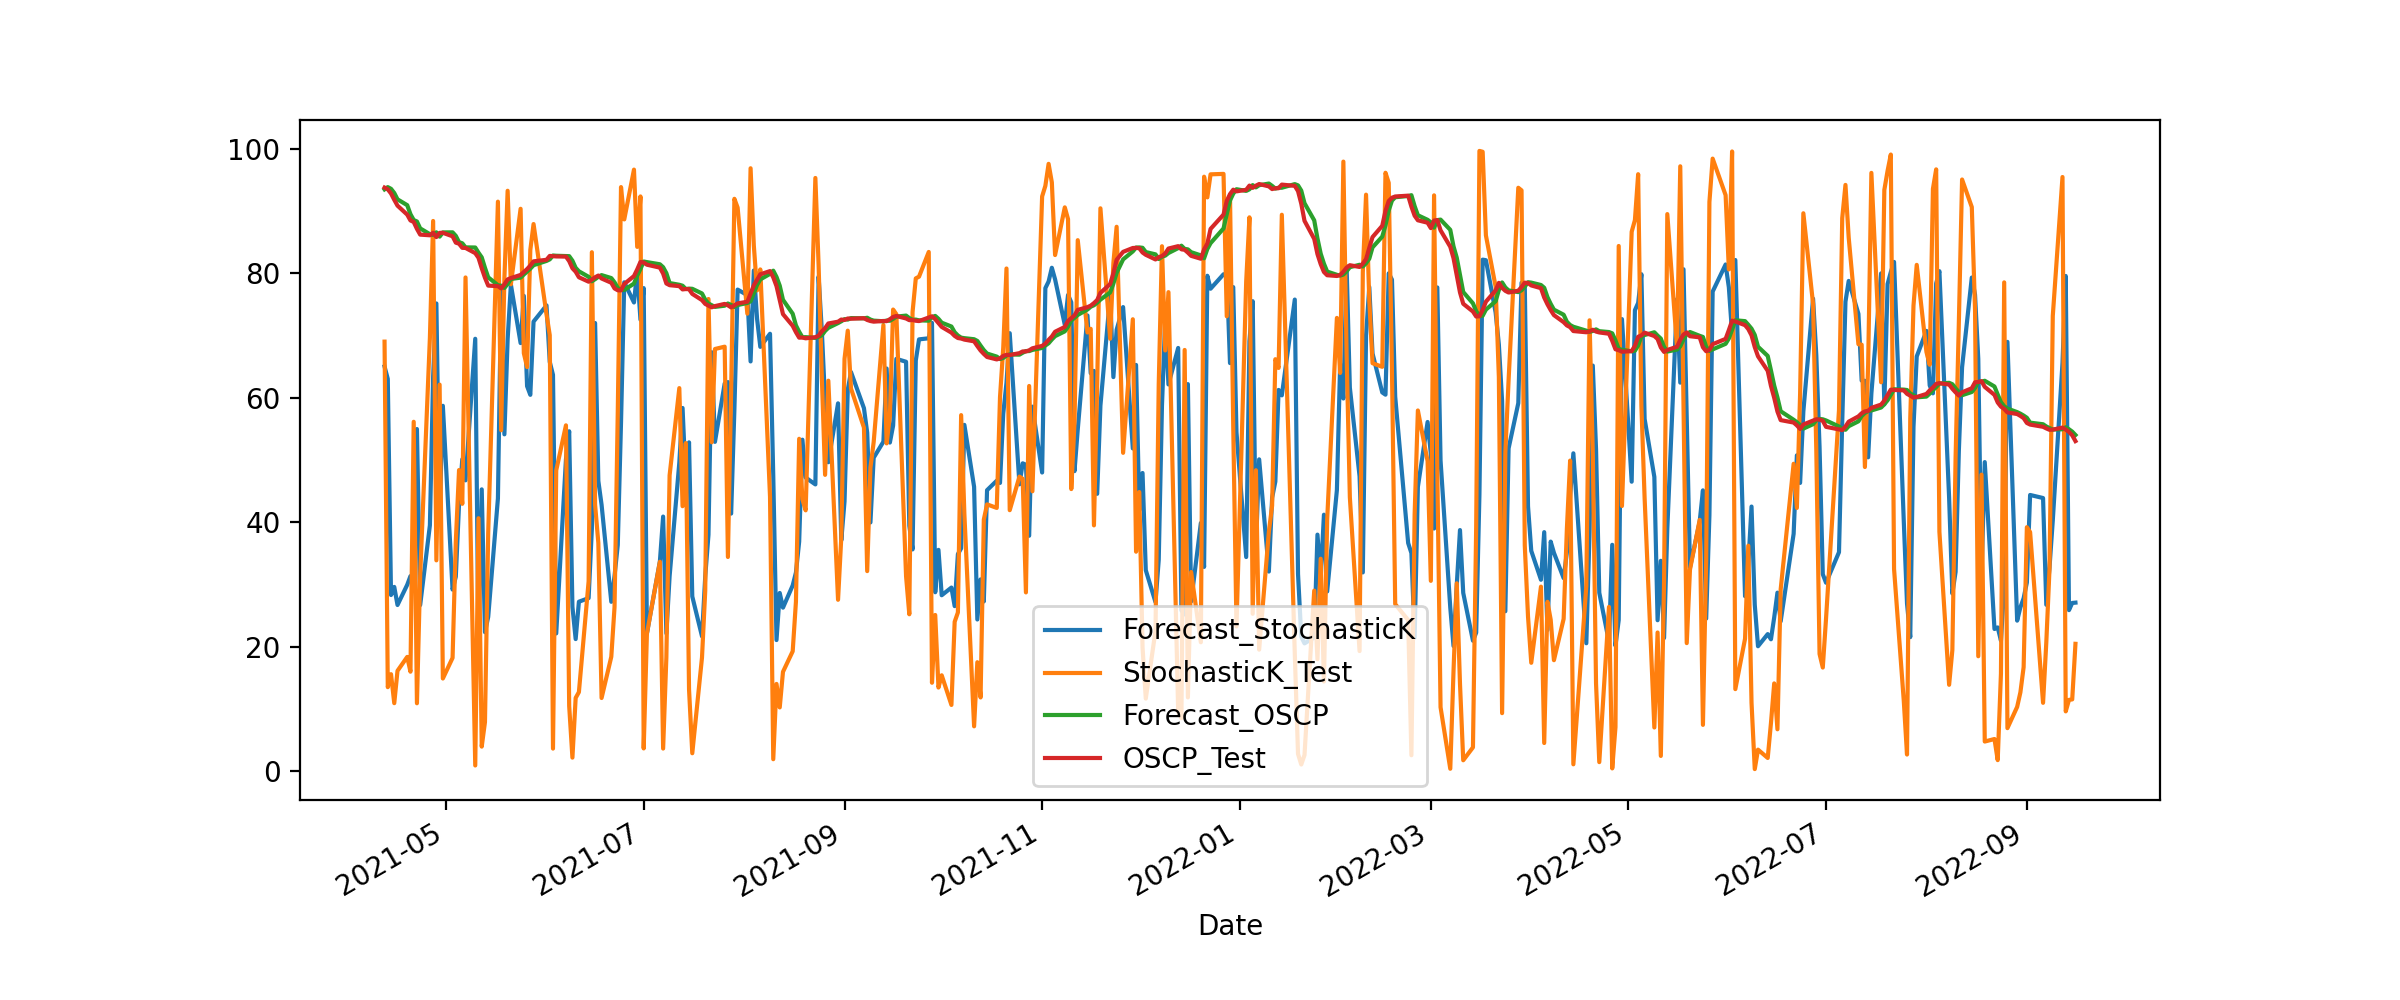

In [35]:
%matplotlib notebook
reload(plt)
subplot = df3.plot(figsize=(12,5))

### feature ASY1

In [36]:
lnCt = np.log(df_type)
lnCt_1 = lnCt.shift(-1)
SYt = lnCt - lnCt_1

In [37]:
ASY1 = SYt*100
df["ASY_1"] = ASY1

### feature ASY2

In [38]:
ASY2 = SYt.rolling(2).mean()
df["ASY_2"] = ASY2

In [39]:
df_type.dropna(inplace=True)

In [40]:
label2 = df.shift(-1)
label2 = label2.rename({'Close':'Close_label', 'ASY_1':'ASY_1_label', 'ASY_2':'ASY_2_label'}, axis='columns')

In [41]:
merged_table_t2 = pd.merge(df, label2, on='Date')
merged_table_t2=merged_table_t2.dropna()

In [42]:
df.tail()

,Close,Label,Ln,Hn,StochasticK,Close_MA5,Close_MA10,OSCP,ASY_1,ASY_2
Date,,,,,,,,,,
2022-09-12,57.939999,53.619999,53.740002,58.139999,9.599991,56.199999,56.448000,54.873865,7.748586,0.034409
2022-09-13,53.619999,53.110001,53.139999,58.139999,11.443688,55.877999,56.109000,54.494774,0.955687,0.043521
2022-09-14,53.110001,52.689999,52.459999,58.139999,11.525959,55.499999,55.790000,53.951884,0.793959,0.008748
2022-09-15,52.689999,52.849998,51.980000,58.139999,20.451087,54.959999,55.406000,53.025012,-0.303203,0.002454
2022-09-16,52.849998,NaN,51.490002,58.139999,NaN,54.041999,54.959999,NaN,NaN,NaN


### Regression

In [43]:
X_ASY1 = merged_table_t2['ASY_1'].values
Y_ASY1 = merged_table_t2['ASY_1_label'].values
X_ASY1 = X_ASY1.reshape(-1,1)

Xtrain = Ytrain = X_test = Y_test = Y_pred = 0
timeSeries = TimeSeriesSplit(n_splits=5)
for itrain, itest in timeSeries.split(X_ASY1):
    X_train,X_test = X_ASY1[itrain],X_ASY1[itest]
    Y_train,Y_test = Y_ASY1[itrain],Y_ASY1[itest]
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

ASY1_X_test = X_test.copy()
ASY1_Y_pred = Y_pred.copy()

In [44]:
X_ASY2 = merged_table_t2['ASY_2'].values
Y_ASY2 = merged_table_t2['ASY_2_label'].values
X_ASY2 = X_ASY2.reshape(-1,1)

Xtrain = Ytrain = X_test = Y_test = Y_pred = 0

for itrain, itest in timeSeries.split(X_ASY2):
    X_train, X_test = X_ASY2[itrain], X_ASY2[itest]
    Y_train, Y_test = Y_ASY2[itrain], Y_ASY2[itest]
    
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)

ASY2_X_test = X_test.copy()
ASY2_Y_pred = Y_pred.copy()

### Error for the regression;using sMAPE/MAPE and MASE error measurements

In [45]:
# Stochastic%K
StochasticK_data_x=pd.DataFrame(StochasticK_X_test)
StochasticK_data_y=pd.DataFrame(StochasticK_Y_pred)
MAPE_StochasticK = (abs(StochasticK_data_x - StochasticK_data_y)/abs(StochasticK_data_x)).sum()/len(StochasticK_data_x)*100
MAPE_StochasticK

0    133.934409
dtype: float64

In [46]:
# OSCP
Oscp_data_x=pd.DataFrame(Oscp_X_test)
Oscp_data_y=pd.DataFrame(Oscp_Y_pred)
MAPE_OSCP = (abs(Oscp_data_x - Oscp_data_y)/abs(Oscp_data_x)).sum()/len(Oscp_data_x)*100
MAPE_OSCP

0    0.191923
dtype: float64

In [47]:
# ASY 1
Asy1_data_x=pd.DataFrame(ASY1_X_test)
Asy1_data_y=pd.DataFrame(ASY1_Y_pred)

MAPE_Asy1 = (abs(Asy1_data_x - Asy1_data_y)/abs(Asy1_data_x)).sum()/len(Asy1_data_x)*100
MAPE_Asy1

0    109.553602
dtype: float64

In [48]:
# ASY 2
Asy2_data_x=pd.DataFrame(ASY2_X_test)
Asy2_data_y=pd.DataFrame(ASY2_Y_pred)

MAPE_Asy2 = (abs(Asy2_data_x - Asy2_data_y)/abs(Asy2_data_x)).sum()/len(Asy2_data_x)*100
MAPE_Asy2

0    inf
dtype: float64

In [49]:
# Stochastic%K
sMAPE_StochasticK = 100/len(StochasticK_data_x) * np.sum(2 * np.abs(StochasticK_data_y - StochasticK_data_x) / (np.abs(StochasticK_data_x) + np.abs(StochasticK_data_y)))
sMAPE_StochasticK

0    36.199563
dtype: float64

In [50]:
# OSCP
sMAPE_OSCP = 100/len(Oscp_data_x) * np.sum(2 * np.abs(Oscp_data_y - Oscp_data_x) / (np.abs(Oscp_data_x) + np.abs(Oscp_data_y)))
sMAPE_OSCP

0    0.191738
dtype: float64

In [51]:
# ASY 1
sMAPE_Asy1 = 100/len(Asy1_data_x) * np.sum(2 * np.abs(Asy1_data_y - Asy1_data_x) / (np.abs(Asy1_data_x) + np.abs(Asy1_data_y)))
sMAPE_Asy1

0    185.87737
dtype: float64

In [52]:
# ASY 2
sMAPE_Asy2 = 100/len(Asy2_data_x) * np.sum(2 * np.abs(Asy2_data_y - Asy2_data_x) / (np.abs(Asy2_data_x) + np.abs(Asy2_data_y)))
sMAPE_Asy2

0    68.775809
dtype: float64

In [53]:
# StochasticK
Errors = abs(StochasticK_data_x - StochasticK_data_y)
Difference = abs(StochasticK_data_y - StochasticK_data_x).sum()/StochasticK_data_x.size
MASE_StochasticK = (Errors/Difference).mean()
MASE_StochasticK

0    1.0
dtype: float64

In [54]:
# OSCP
Errors = Difference = 0
Errors = abs(Oscp_data_x- Oscp_data_y)
Difference = abs(Oscp_data_y - Oscp_data_x).sum()/Oscp_data_x.size
MASE_OSCP = (Errors/Difference).mean()
MASE_OSCP 

0    1.0
dtype: float64

In [55]:
# ASY 1
Errors = Difference = 0
Errors = abs(Asy1_data_x - Asy1_data_y)
Difference = abs(Asy1_data_y - Asy1_data_x).sum()/Asy1_data_x.size
MASE_Asy1 = (Errors/Difference).mean()
MASE_Asy1

0    1.0
dtype: float64

In [56]:
# ASY 2
Errors = Difference = 0
Errors = abs(Asy2_data_x - Asy2_data_y)
Difference = abs(Asy2_data_y - Asy2_data_x).sum()/Asy2_data_x.size
MASE_Asy2 = (Errors/Difference).mean()
MASE_Asy2

0    1.0
dtype: float64

### Decision based on regression

In [57]:
Final_Data=pd.DataFrame()
Final_Data=df[['Close','StochasticK','OSCP','ASY_1','ASY_2','Label']]

In [58]:
x_model=np.array(Final_Data.drop(['Label'], 1))
y_model=np.array(Final_Data['Label'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [59]:
# split the data into 80% and 20%
from sklearn.model_selection import TimeSeriesSplit
tscv=TimeSeriesSplit(n_splits=5)
for train_index,test_index in tscv.split(x_model):
    x_train,x_test= x_model[train_index],x_model[test_index]
    y_train,y_test= y_model[train_index],y_model[test_index]

### Decison Design

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
inp =np.array(test_data['Expected Output'])
inp=inp.reshape(-1,1)

In [61]:
# short term and long term averages setting
short_window = 40
long_window = 100
df["signal"] = 0.0
df["short"] = df["Close"].rolling(window = short_window, min_periods=1, center=False).mean()
df["long"] = df["Close"].rolling(window = long_window, min_periods=1, center=False).mean()
df["signal"][short_window:]=np.where(df["short"][short_window:]>df["long"][short_window:],1.0,0.0)
df["positions"] = df["signal"].diff()
df.head()

,Close,Label,Ln,Hn,StochasticK,Close_MA5,Close_MA10,OSCP,ASY_1,ASY_2,signal,short,long,positions
Date,,,,,,,,,,,,,,
2013-12-31,21.750000,21.660000,NaN,NaN,NaN,NaN,NaN,NaN,0.414652,NaN,0.0,21.7500,21.7500,NaN
2014-01-02,21.660000,20.969999,NaN,NaN,NaN,NaN,NaN,NaN,3.237442,0.018260,0.0,21.7050,21.7050,0.0
2014-01-03,20.969999,20.670000,NaN,NaN,NaN,NaN,NaN,NaN,1.440943,0.023392,0.0,21.4600,21.4600,0.0
2014-01-06,20.670000,21.730000,NaN,NaN,83.846092,NaN,NaN,NaN,-5.001040,-0.017800,0.0,21.2625,21.2625,0.0
2014-01-07,21.730000,23.870001,20.639999,21.940001,83.678781,21.356,NaN,NaN,-9.392870,-0.071970,0.0,21.3560,21.3560,0.0


<IPython.core.display.Javascript object>


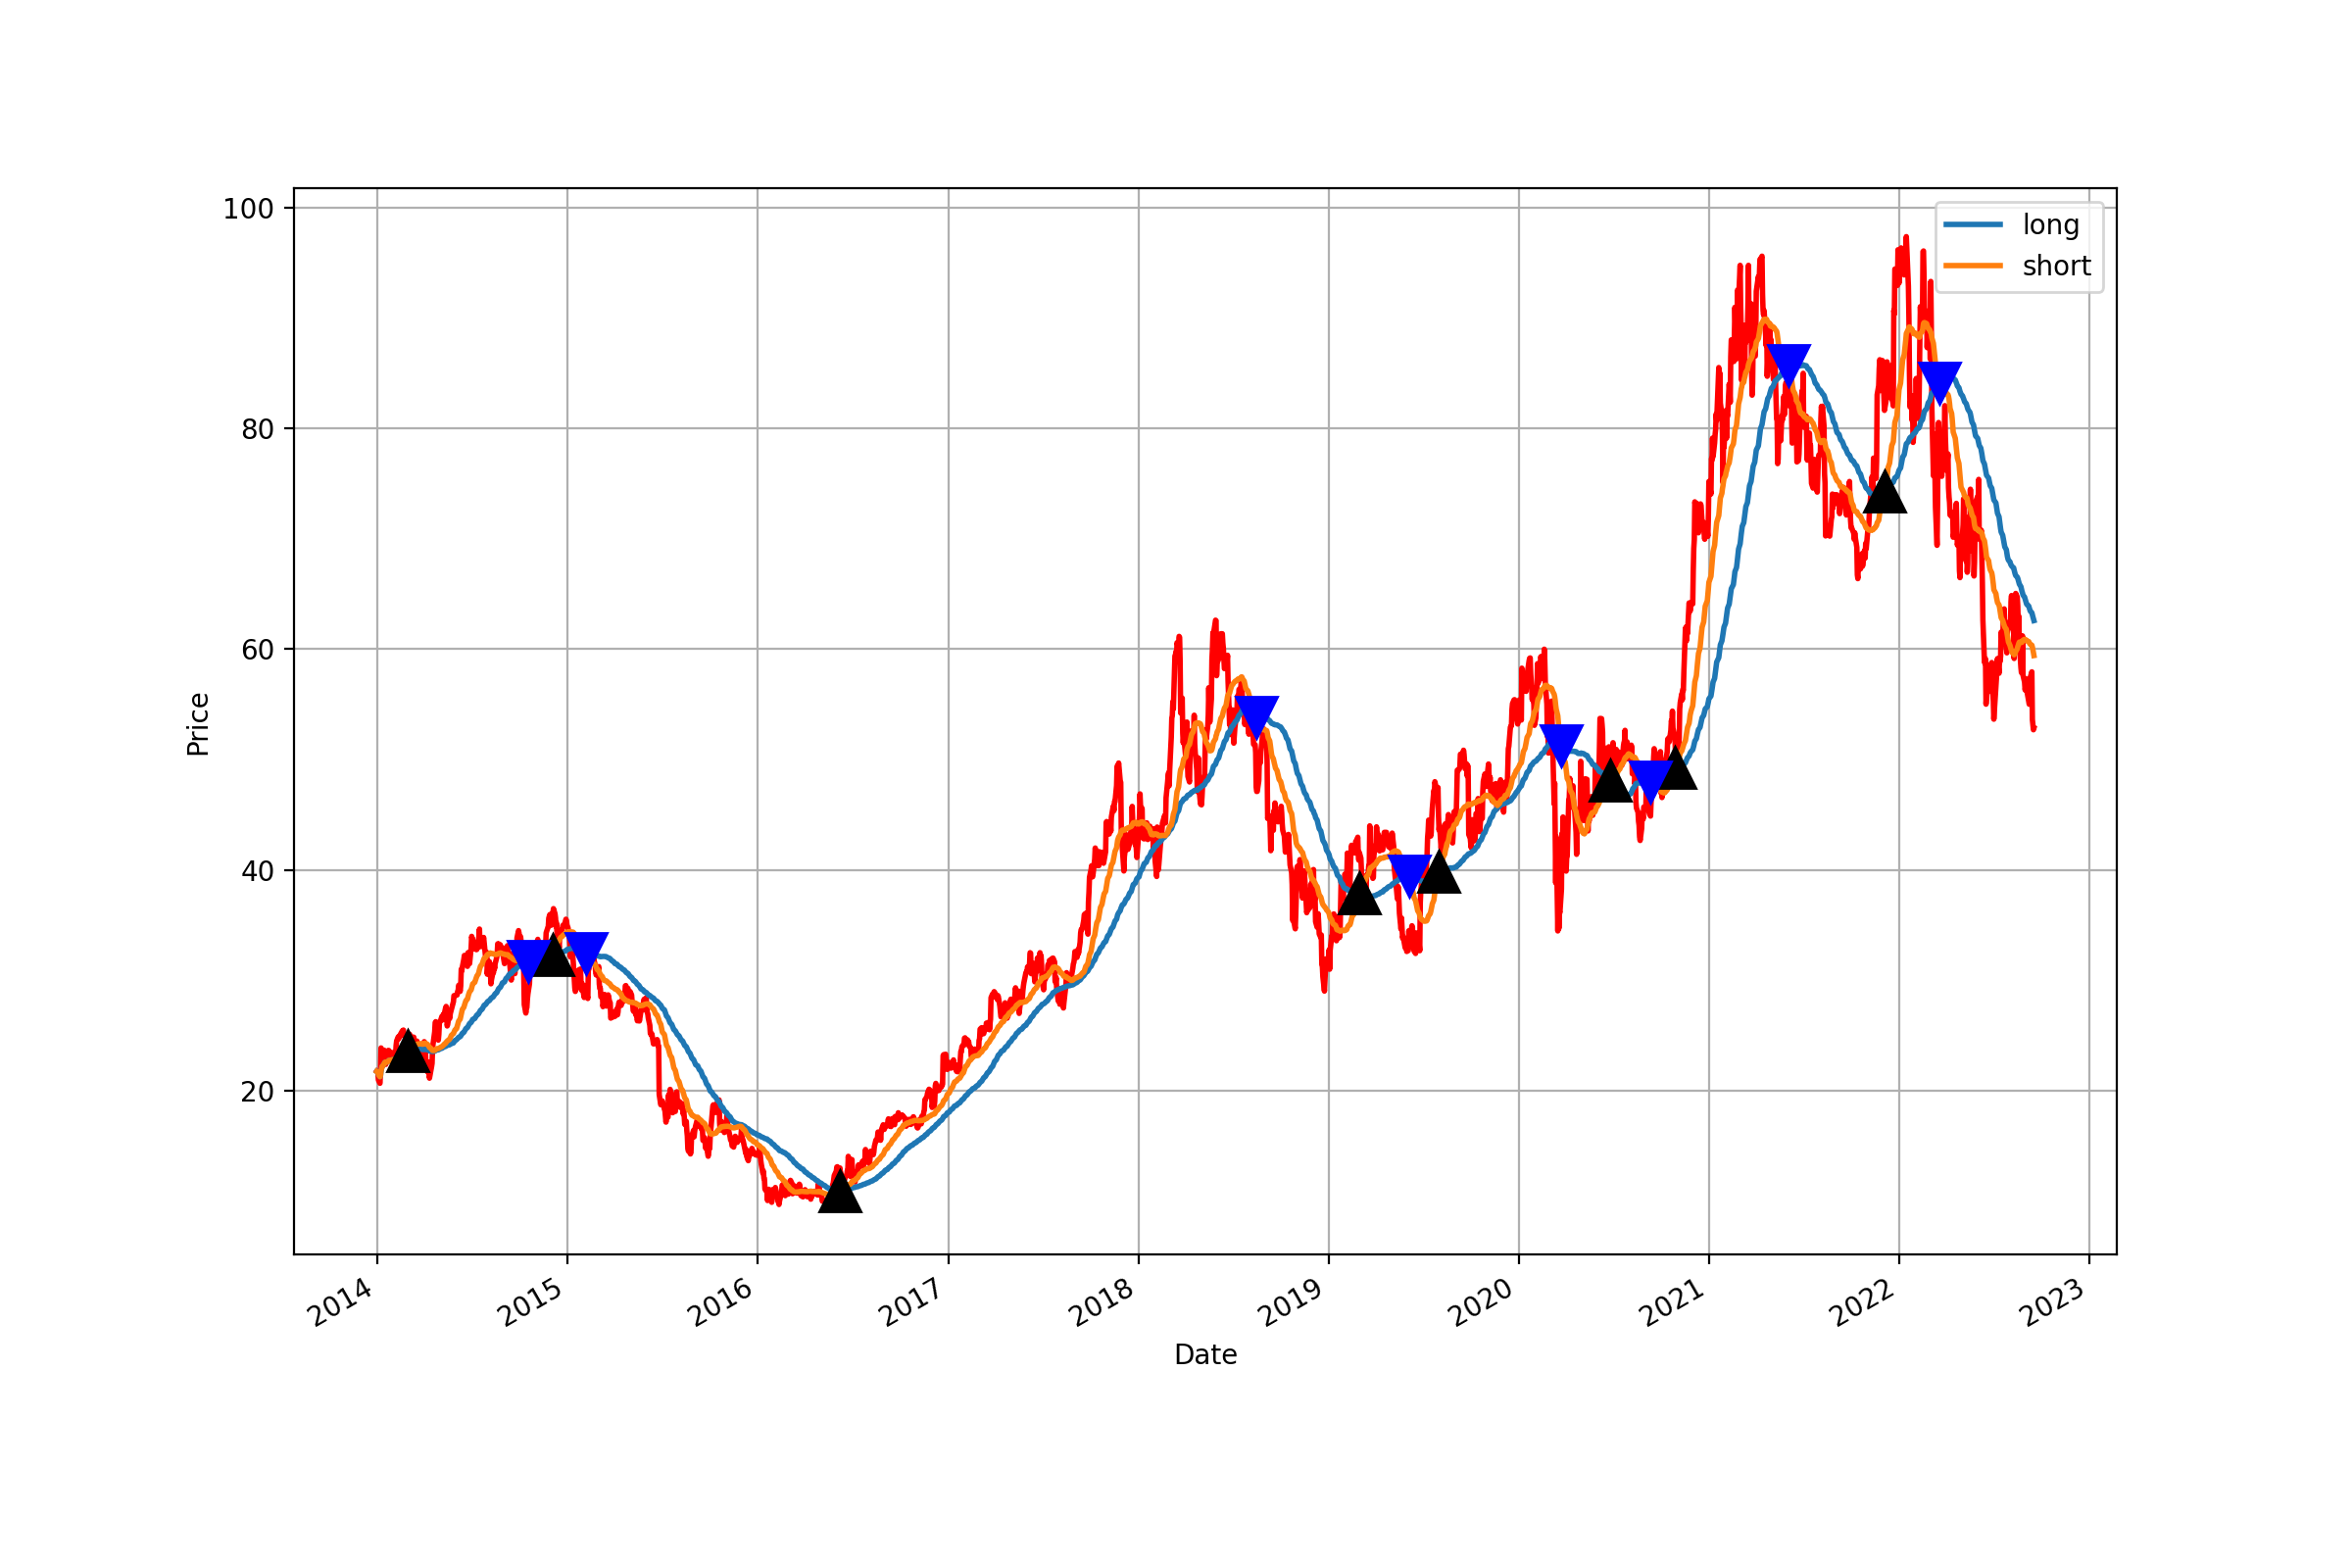

In [65]:
fig = plt.figure(figsize=(12,8))
# subplot and labels
ax1 = fig.add_subplot(111, ylabel='Price')
# plot prices
df['Close'].plot(ax=ax1, color='r', lw=2.)
# plot the moving averages
df[["long","short"]].plot(ax=ax1, lw=2.)
# plot the buy signals
ax1.plot(df.loc[df.positions == 1.0].index, df.short[df.positions == 1.0], '^', markersize=15, color='black')
# plot the sell signals
ax1.plot(df.loc[df.positions == -1.0].index, df.long[df.positions == -1.0], 'v', markersize=15, color='b')
plt.grid()
plt.show()